Homework #1
===========

**Due:** Feb 16th 2015

**How to submit:** Fork the homeworks git repository and write your homework in an IPython notebook in a directory named `hw1/$NAME`, replacing `$NAME` with your name w/o any spaces (i.e., `hw1/MarioJuric`). To submit, issue a pull request.

Problem 1: Querying and data analysis with SDSS
===============================================

Open an account on the SDSS Catalog Access Service (CAS) website, http://skyserver.sdss.org/CasJobs/. The documentation for CAS is at http://skyserver.sdss.org/casjobs/Guide.aspx, and the documentation showing the contents of various *tables* and *views* -- also known as the *schema browser* -- is at http://skyserver.sdss.org/dr12/en/help/browser/browser.aspx. While we haven't explicitly discussed views, you may think of them as tables.

Tasks
-----

1. **[2 POINTS]:** Use the schema browser to familiarize yourself with the contents of a view named `Star`. Then:
   * Write (and execute) an SQL query to count how many stars have been observed with SDSS (in the current Data Release 12).
   
### Solution: 
   ```
   SELECT COUNT(*) FROM Star
   ```

```
   Result: 260,562,744
```

   * Write (and execute) an SQL query to count how many observations there are in `u`, `g`, `r`, `i` and `z` bands, and the average observed magnitude in each band. How does the SDSS database record missing (magnitude) data?

### Solution:

```
   SELECT MIN(u), MAX(u) FROM Star
```

```
   -9999	35.7823
```
   
``` 
   SELECT COUNT(*), AVG(u) FROM Star WHERE u > 0
   SELECT COUNT(*), AVG(g) FROM Star WHERE g > 0
   SELECT COUNT(*), AVG(r) FROM Star WHERE r > 0
   SELECT COUNT(*), AVG(i) FROM Star WHERE i > 0
   SELECT COUNT(*), AVG(z) FROM Star WHERE z > 0
```

```
   Results: u: 260,561,128   23.329
   Results: g: 260,560,429   22.216
   Results: r: 260,561,511   21.134 
   Results: i: 260,560,369   20.405
   Results: z: 260,561,329   19.884
```
   
2.. **[2 POINTS]:** Write an SQL query to select the positions ($\alpha$, also known as `ra`, and $\delta$, also know as `dec`) and the extinction-corrected (a.k.a. *dereddened*) `g` and `r`-band magnitudes of all stars bounded by $225 < \alpha < 235$ and $-2.5 < \delta < 4$. Your query should store the outputs into a temporary table in MyDB. Download it as a FITS file. Use the `astropy.io.fits` module to load the table data into Python, then store it into a local sqlite database (using `Pandas` to_sql() functions).

### Solution

SQL Query:

``` SQL
SELECT ra, dec, dered_g, dered_r
INTO mydb.pal5
FROM Star
WHERE 225 < ra AND ra < 235 AND -2.5 < dec AND dec < 4
```

In [3]:
# Load with astropy.Table store into a sqlite database using Pandas
from astropy.table import Table
import pandas as pd
import numpy as np
import sqlite3

data = Table.read('pal5_mjuric2.fit')
df = pd.DataFrame(np.array(data))

con = sqlite3.connect('pal5.db')
df.to_sql('stars', con, if_exists='replace', index=False)

3.. **[2 POINTS]:** In an IPython notebook, make an $ra$ vs $dec$ scatter plot of the data. Note that the right ascension by convention increases from right to left; make sure your plot reflects that. What do you see near $\alpha \sim 229$ and $\delta \sim 0$? Do know what is this object?

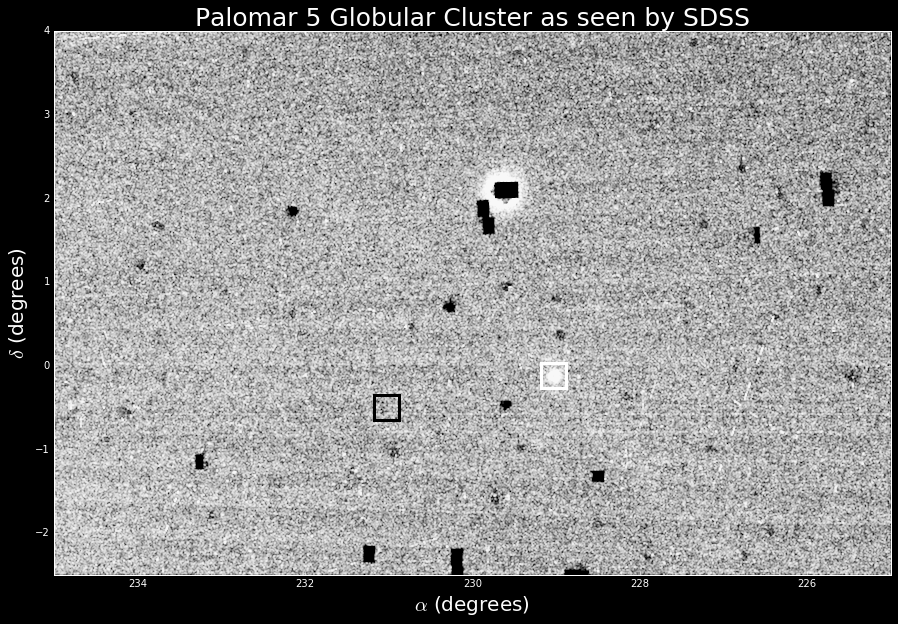

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.style.use('dark_background')

def plot_stars(ra, dec, s=.1, marker='.'):
    plt.figure(figsize=(10*1.5, 6.5*1.5))
    plt.scatter(ra, dec, s=s, marker=marker, color='white')
    plt.xlim(ra.min(), ra.max())
    plt.ylim(dec.min(), dec.max())
    plt.gca().invert_xaxis()
    plt.xlabel(r"$\alpha$ (degrees)", fontsize=20)
    plt.ylabel(r"$\delta$ (degrees)", fontsize=20)
    plt.title('Palomar 5 Globular Cluster as seen by SDSS', fontsize=25)

plot_stars(df['ra'], df['dec'])

# Plot a rectangle bounding Pal5, and a control region
import matplotlib.patches as patches
pal5ra, pal5dec = 229.03, -0.12
ctrlra, ctrldec = 231.03, -0.5
w, h = 0.3, 0.3
plt.gca().add_patch( patches.Rectangle( (pal5ra-w/2, pal5dec-h/2), w, h, linewidth=3, edgecolor='white', fill=False) )
plt.gca().add_patch( patches.Rectangle( (ctrlra-w/2, ctrldec-h/2), w, h, linewidth=3, edgecolor='black', fill=False) )

4.. **[2 POINTS]:** Select a subset of the data in a region (a rectangle is fine!) tightly bounding the observed object. Select data in another, equally sized region, nearby but *away* from the object. Do the selection in two ways: with an SQL query of your local sqlite database, and using the indexing operators in Python (the square brackets '[]'). Show that the two give identical results.

In [5]:
# Select using the SQL Query
query_pattern = "SELECT * FROM stars WHERE ra BETWEEN %f AND %f AND dec BETWEEN %f AND %f"
pal5sql = pd.read_sql(query_pattern % (pal5ra - w/2, pal5ra + w/2, pal5dec - h/2, pal5dec + h/2), con)
ctrlsql = pd.read_sql(query_pattern % (ctrlra - w/2, ctrlra + w/2, ctrldec - h/2, ctrldec + h/2), con)

# Select with Pandas
df = pd.read_sql("SELECT * FROM stars", con)
ra, dec = df['ra'], df['dec']
pal5 = df[(pal5ra - w/2 <= ra) & (ra <= pal5ra + w/2) & (pal5dec - h/2 <= dec) & (dec <= pal5dec + h/2)]
ctrl = df[(ctrlra - w/2 <= ra) & (ra <= ctrlra + w/2) & (ctrldec - h/2 <= dec) & (dec <= ctrldec + h/2)]

In [7]:
# Demonstrate that the two are equal
print np.all(pal5sql.sort_values(by=['ra', 'dec']).values == pal5.sort_values(by=['ra', 'dec']).values)
print np.all(ctrlsql.sort_values(by=['ra', 'dec']).values == ctrl.sort_values(by=['ra', 'dec']).values)

True
True


5.. **[2 POINTS]:** Make two side-by-side scatter plots of the (dereddened) $g-r$ color vs $g$-band magnitude. Note that the magnitude axis, by convention, always increases from top to bottom; make sure your plot reflects that. Compare the two and describe what you see.

[u'seaborn-darkgrid', u'seaborn-notebook', u'classic', u'seaborn-ticks', u'grayscale', u'bmh', u'seaborn-talk', u'dark_background', u'ggplot', u'fivethirtyeight', u'seaborn-colorblind', u'seaborn-deep', u'seaborn-whitegrid', u'seaborn-bright', u'seaborn-poster', u'seaborn-muted', u'seaborn-paper', u'seaborn-white', u'seaborn-pastel', u'seaborn-dark', u'seaborn-dark-palette']


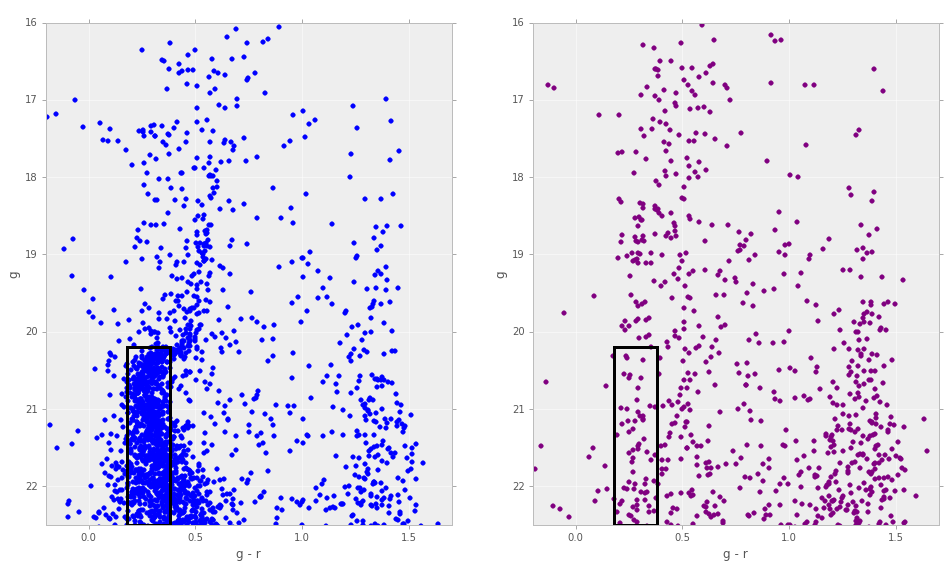

In [8]:
print plt.style.available
plt.style.use('ggplot')
plt.style.use('bmh')

# Plot side-by-side color-magnitude diagrams for the Pal5 and control field
def make_cmd(ax, gr, g, color, title):
    ax.scatter(gr, g, color=color)
    ax.set_title(title, loc='right')
    ax.set_ylim(22.5, 16);
    ax.set_xlim(-0.2, 1.7)
    ax.set_xlabel('g - r');
    ax.set_ylabel('g')

    ax.add_patch( patches.Rectangle( (0.18, 20.2), 0.2, 2.3, linewidth=3, edgecolor='black', fill=False) )

fig, (ax1, ax2)= plt.subplots(1, 2, figsize=(16,9))
make_cmd(ax1, pal5['dered_g'] - pal5['dered_r'], pal5['dered_g'], 'blue', 'Palomar 5 field')
make_cmd(ax2, ctrl['dered_g'] - ctrl['dered_r'], ctrl['dered_g'], 'purple', 'Control field')

A clear main sequence is visible on the left color-magnitude diagram, while none exists in the control field.

6.. **[2 POINTS]:** Identify a region in $g-r$ vs $g$ plot where the difference between the two plots appears greatest. From your original sample, select stars only present in that *color-magnitude* box, and plot them in $ra$ vs $dec$ scatter plot. Do you notice anything interesting?

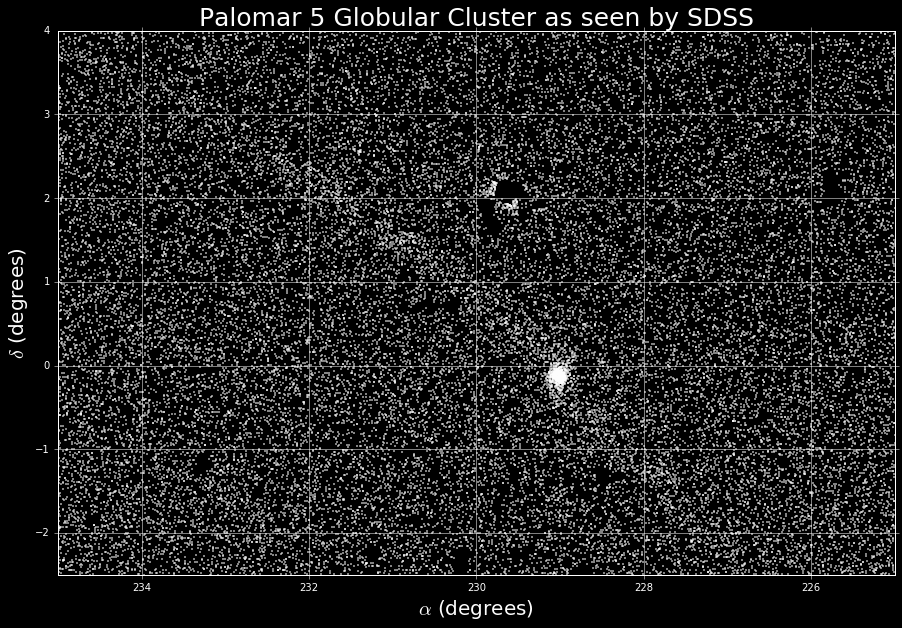

In [9]:
plt.style.use('dark_background')

g = df['dered_g']
gr = df['dered_g'] - df['dered_r']
sel = df[(0.18 < gr) & (gr < 0.38) & (20.2 < g) & (g < 22.5)]

plot_stars(sel['ra'], sel['dec'], s=1, marker='o')

Note the two tidal streams extending diagonally (top-left to bottom-right) from the main body of Palomar 5.

7.. **Extra credit [up to 2 POINTS]:** : how would you make the determination of the $g-r$ vs $g$ selection box more quantitative?

For example, you could bin the two color-magnitude diagrams and only select the bins that maximize the total number of Pal5 stars vs. background stars.

Problem 2: Importing data into the Large Survey Database
========================================================

Most users access SDSS data through the CAS database server. However, one can still download the entire catalog in bulk as a collection of FITS files from the Science Archive Server (http://dr12.sdss3.org/).

The most commonly used columns of the `PhotoObj` table in SDSS database (the photometric catalog from which views such as `Star` are derived) are stored in the so-called [*sweep files*](http://dr12.sdss3.org/datamodel/files/PHOTO_SWEEP/RERUN/calibObj.html) on the Science Archive Server. The files themselves are located in http://data.sdss3.org/sas/dr12/boss/sweeps/dr9/301/ and organized by SDSS run, camera column, and the type of objects the files contain (`sky`, `star`, `gal`).

We will use these files to practice writing YAML schema files and import data into LSD.

Tasks
-----
* **[2 POINTS]:** Read about the [data contained in sweep files](http://dr12.sdss3.org/datamodel/files/PHOTO_SWEEP/RERUN/calibObj.html) for stars. Write a corresponding YAML LSD schema file. Make sure it consists of (at least) four tablets: basic quantities, photometry, image, resolve and calibration quantities, and the 2MASS match information. Create an LSD table with that schema.
* **[1 POINT]:** Download all files belonging to run 94, from http://data.sdss3.org/sas/dr12/boss/sweeps/dr9/301/. Use `lsd-import` to import these files.

In [10]:
! rm -rf run94data
! mkdir run94data
for camcol in xrange(1, 7):
    ! (cd run94data && wget -nv -nc http://data.sdss3.org/sas/dr12/boss/sweeps/dr9/301/calibObj-000094-{camcol}-star.fits.gz)

2016-03-03 10:19:40 URL:http://data.sdss3.org/sas/dr12/boss/sweeps/dr9/301/calibObj-000094-1-star.fits.gz [54951150/54951150] -> "calibObj-000094-1-star.fits.gz" [1]
2016-03-03 10:19:53 URL:http://data.sdss3.org/sas/dr12/boss/sweeps/dr9/301/calibObj-000094-2-star.fits.gz [63064519/63064519] -> "calibObj-000094-2-star.fits.gz" [1]
2016-03-03 10:20:01 URL:http://data.sdss3.org/sas/dr12/boss/sweeps/dr9/301/calibObj-000094-3-star.fits.gz [51613691/51613691] -> "calibObj-000094-3-star.fits.gz" [1]
2016-03-03 10:20:07 URL:http://data.sdss3.org/sas/dr12/boss/sweeps/dr9/301/calibObj-000094-4-star.fits.gz [53581389/53581389] -> "calibObj-000094-4-star.fits.gz" [1]
2016-03-03 10:20:16 URL:http://data.sdss3.org/sas/dr12/boss/sweeps/dr9/301/calibObj-000094-5-star.fits.gz [56030080/56030080] -> "calibObj-000094-5-star.fits.gz" [1]
2016-03-03 10:20:25 URL:http://data.sdss3.org/sas/dr12/boss/sweeps/dr9/301/calibObj-000094-6-star.fits.gz [56646748/56646748] -> "calibObj-000094-6-star.fits.gz" [1]


In [13]:
# Inspect one of the FITS files
data = Table.read('run94data/calibObj-000094-6-star.fits.gz')

In [14]:
# Print out the column names and types
for column in data.dtype.names:
    print "(%s, %s)" % (column.lower(), data[column].dtype)

(run, >i2)
(rerun, |S3)
(camcol, uint8)
(field, >i2)
(id, >i2)
(objc_type, >i4)
(objc_flags, >i4)
(objc_flags2, >i4)
(objc_rowc, >f4)
(rowvdeg, >f4)
(rowvdegerr, >f4)
(colvdeg, >f4)
(colvdegerr, >f4)
(rowc, >f4)
(colc, >f4)
(m_rr_cc, >f4)
(m_rr_cc_psf, >f4)
(flags, >i4)
(flags2, >i4)
(psp_status, >i4)
(ra, >f8)
(dec, >f8)
(psf_fwhm, >f4)
(extinction, >f4)
(skyflux, >f4)
(psfflux, >f4)
(psfflux_ivar, >f4)
(fiberflux, >f4)
(fiberflux_ivar, >f4)
(fiber2flux, >f4)
(fiber2flux_ivar, >f4)
(modelflux, >f4)
(modelflux_ivar, >f4)
(calib_status, >i4)
(nmgypercount, >f4)
(resolve_status, >i4)
(thing_id, >i4)
(ifield, >i4)
(balkan_id, >i4)
(ndetect, >i4)
(pm_match, >i4)
(pmra, >f4)
(pmdec, >f4)
(pmraerr, >f4)
(pmdecerr, >f4)
(pm_sigra, >f4)
(pm_sigdec, >f4)
(pm_nfit, >i4)
(pm_dist22, >f4)
(tmass_j, >f4)
(tmass_j_ivar, >f4)
(tmass_h, >f4)
(tmass_h_ivar, >f4)
(tmass_k, >f4)
(tmass_k_ivar, >f4)
(tmass_ph_qual, |S3)
(tmass_rd_flg, >i2)
(tmass_bl_flg, >i2)
(tmass_cc_flg, |S3)
(tmass_gal_contam, uint8)


In [15]:
# Create the corresponding YAML file (just print it out here)
! cat sdss.yaml

filters: {complevel: 5, complib: blosc}
schema:
  common:
    primary_key: id
    spatial_keys: [ra, dec]
    columns:
    - [ra, f8] 
    - [dec, f8] 
    - [run, u2] 
    - [rerun, S3] 
    - [camcol, u1] 
    - [field, i2] 
    - [id, u8] 
    - [objc_type, i4] 
    - [flags, 5i4] 
    - [flags2, 5i4] 
    - [objc_flags, i4] 
    - [objc_flags2, i4] 
  extra:
    columns:
    - [zhedflag, i2] 
    - [objc_rowc, f4] 
    - [rowvdeg, f4] 
    - [rowvdegerr, f4] 
    - [rowc, 5f4] 
    - [colvdeg, f4] 
    - [colvdegerr, f4] 
    - [colc, 5f4] 
    - [m_rr_cc, 5f4]
    - [m_rr_cc_psf, 5f4]
  photometry:
    columns:
    - [skyflux, 5f4] 
    - [psfflux, 5f4] 
    - [psfflux_ivar, 5f4] 
    - [modelflux, 5f4] 
    - [modelflux_ivar, 5f4] 
    - [extinction, 5f4] 
    - [aperflux6, 5f4] 
  calib:
    columns:
    - [psp_status, 5i4] 
    - [psf_fwhm, 5f4] 
    - [resolve_status, i4] 
    - [thing_id, i4] 
    - [ifield, i4] 
    - [balkan_id, i4] 
    - [ndetect, i4] 
    - [calib_status

In [18]:
# Create an empty directory for my new database...
! rm -rf run94db
! mkdir run94db

# ... and point the LSD_DB environmental variable to it
import os, os.path
os.environ["LSD_DB"] = os.path.join(os.getcwd(), 'run94db')
print os.environ["LSD_DB"]

/Users/mjuric/projects/teaching/astr597b_w16/astr597b_wi16_hw/hw1/solution/run94db


In [20]:
# Create the table
! lsd-admin create table --drop-existing --schema=sdss.yaml sdss94

In [20]:
! lsd-import fits sdss94 run94data/calibObj-000094-*-star.fits.gz

Importing from 6 pieces:
  ===> Imported run94data/calibObj-000094-3-star.fits.gz                               [1/6, 16.67%] + 124832/124832     124832 (0/2 min.)
  ===> Imported run94data/calibObj-000094-1-star.fits.gz                               [2/6, 33.33%] + 133515/133515     258347 (0/1 min.)
  ===> Imported run94data/calibObj-000094-6-star.fits.gz                               [3/6, 50.00%] + 138113/138113     396460 (0/1 min.)
  ===> Imported run94data/calibObj-000094-2-star.fits.gz                               [4/6, 66.67%] + 155355/155355     551815 (1/1 min.)
  ===> Imported run94data/calibObj-000094-4-star.fits.gz                               [5/6, 83.33%] + 130027/130027     681842 (1/1 min.)
  ===> Imported run94data/calibObj-000094-5-star.fits.gz                               [6/6, 100.00%] + 136292/136292     818134 (1/1 min.)
done

-------- committing 20150310093028.047280 [sdss94] ---------
[sdss94] Updating tablet catalog: [256 el.]::::::::::::::::::::>  0.23 se

* **[1 POINT]:** Use `lsd-footprint` to compute the footprint of the run, and plot the result.

In [59]:
! lsd-footprint --resolution=3 sdss94 foot94.fits

 [48 el.]::::::::::::::::::::>  3.02 sec
Objects: 818134.0


In [85]:
img = pyfits.getdata('foot94.fits')
img.shape

(3601, 7200)

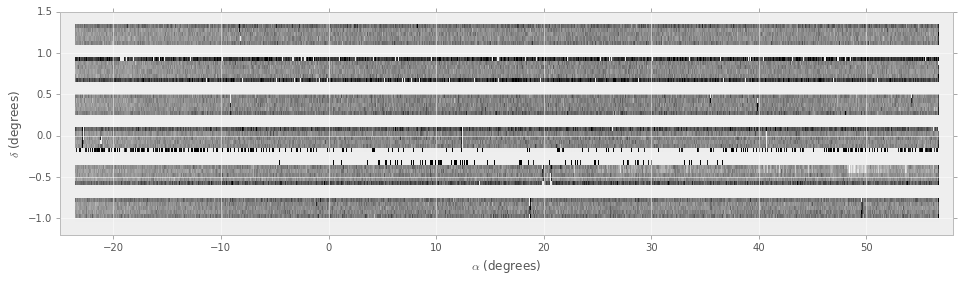

In [109]:
# Plot the result (use np.roll to re-center the footprint at ra=0)
from matplotlib.colors import LogNorm

plt.style.use('ggplot')
plt.style.use('bmh')

xmin, xmax = -25, 58
img2 = np.roll(np.fliplr(img), 1800*2, axis=1)[888*2:915*2, (1800+xmin*10)*2:(1800+xmax*10)*2]
plt.figure(figsize = (16, 4))
imshow(img2, origin='lower', extent=(xmin, xmax, -1.2, 1.5), interpolation='none', aspect='auto', cmap=plt.cm.gray, norm=LogNorm(vmin=1, vmax=img.max()))

xlabel(r'$\alpha$ (degrees)')
ylabel(r'$\delta$ (degrees)')

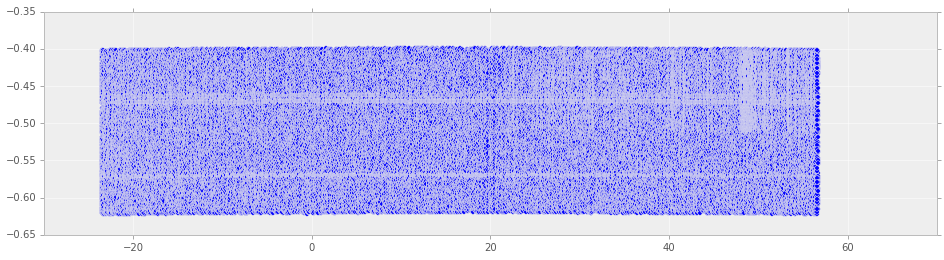

In [108]:
# Check that we got it right
data = pyfits.getdata('run94data/calibObj-000094-2-star.fits.gz')

ra = data['ra']
ra[ra > 180] = ra[ra > 180] - 360

plt.figure(figsize = (16, 4))
plt.scatter(ra, data['dec'])